# Risk-Neutral Pricing of Weather Derivatives

YouTube Tutorial (Published Oct 17, 2022): https://youtu.be/aMgWz2dWyIE

## Quick Summary on Weather Derivative Contract Features

<b>Aim</b>: we want to price temperature options.

<b>Underlying</b>: HDD/CDD index over given period.

The underlying over a temperature option is the heating/cooling degree days (HDD/CDD) index based on 'approximation' of average temperature and reference (/base) temperature.

### 1. Temperature Underlying
$\large T_n = \frac{T^{max}+T^{max}}{2}$

### 2. Degree Days
For a day $n \in N$:
- $\large HDD_n = (T_{ref}-T_n)^+$
- $\large CDD_n = (T_n - T_{ref})^+$

### 3. Payoff Functions
Here the buyer of an option with receive an amount:
$\large \xi = f(DD)$

Payoff function $f$ is computed on the cumulative index over a period $P$:
   - heating degree seasons $DD = H_n = HDD^{N} = \sum^N_n HDD_n$
   - cooling degree seasons $DD = C_n = CDD^{N} = \sum^N_n CDD_n$

### 4. Popular Payoff Functions

#### Call with Cap

$\large \xi = min\{\alpha(DD - K)^+, C\}$

<b>where:</b>
 - payoff rates $\large \alpha$ is commonly US$\$2,500$ or US$\$5,000$
 - while caps $\large C$ is commonly US$\$500,000$ or US$\$1,000,000$

## Quick Summary on Temperature Modelling

<b>NOTE:</b> Everything we have done so far in this series has been under the Physical probability measure $\large \mathbb{P}$, including for our parameter estimation of the following models.

In [5]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
from scipy.integrate import quad
from scipy import stats, interpolate

max_temp = pd.read_csv('https://raw.githubusercontent.com/ASXPortfolio/jupyter-notebooks-data/main/maximum_temperature.csv')
min_temp = pd.read_csv('https://raw.githubusercontent.com/ASXPortfolio/jupyter-notebooks-data/main/minimum_temperature.csv')

def datetime(row):
    return dt.datetime(row.Year,row.Month,row.Day)

max_temp['Date'] = max_temp.apply(datetime,axis=1)
min_temp['Date'] = min_temp.apply(datetime,axis=1)
max_temp.set_index('Date', inplace=True)
min_temp.set_index('Date', inplace=True)
drop_cols = [0,1,2,3,4,6,7]
max_temp.drop(max_temp.columns[drop_cols],axis=1,inplace=True)
min_temp.drop(min_temp.columns[drop_cols],axis=1,inplace=True)
max_temp.rename(columns={'Maximum temperature (Degree C)':'Tmax'}, inplace=True)
min_temp.rename(columns={'Minimum temperature (Degree C)':'Tmin'}, inplace=True)

temps = max_temp.merge(min_temp,how='inner',left_on=['Date'],right_on=['Date'])

def avg_temp(row):
    return (row.Tmax+row.Tmin)/2

temps['T'] = temps.apply(avg_temp,axis=1)

# drop na values here
temps = temps.dropna()

temp_t = temps['T'].copy(deep=True)
temp_t = temp_t.to_frame()
first_ord = temp_t.index.map(dt.datetime.toordinal)[0]

temp_vol = temps['T'].copy(deep=True).to_frame()
temp_vol['day'] = temp_vol.index.dayofyear
temp_vol['month'] = temp_vol.index.month

vol = temp_vol.groupby(['day'])['T'].agg(['mean','std'])
days = np.array(vol['std'].index)
T_std = np.array(vol['std'].values)

temp_t.head()

,T
Date,
1859-01-01,19.45
1859-01-02,20.05
1859-01-03,19.75
1859-01-04,21.05
1859-01-05,20.75


### Modified mean-reverting Ornstein-Uhlenbeck (OU) process

Our model for our mean-reverting Daily Average Temperature (DAT) is described in the following OU process SDE with estimated parameters.

$\large dT_t = \left[\frac{d\bar{T_t}}{dt} + 0.438 (\bar{T_t} - T_t)\right]dt + \sigma_t dW_t$

Where our changing average of DAT $\large \bar{T_t}$ is:

$\large \bar{T_t} = 16.8 + (3.32e-05)t + 5.05 sin((\frac{2\pi}{365.25})t + 1.27)$

First derivative does not need finite difference approximation here because the function is differentiable $\large \bar{T'_t}$

$\large \bar{T'_t} = (3.32e-05) + 5.05 (\frac{2\pi}{365.25}) cos((\frac{2\pi}{365.25})t + 1.27)$

Where the date <b>01-Jan 1859</b> corresponds with the first ordinal number 0.

### Volatility of Temperature Process

The volatility estimator is based on the the quadratic variation $\Large \sigma_t^2$ of of the temperature process $\Large T_t$

 $\Large \hat{\sigma}^2_t = \frac{1}{N_t} \sum^{N-1}_{i=0} (T_{i+1} - T_i)^2 $

$\Large \sigma_t$ is the dynamic volatility of the Temperature process. This could be both daily (as with our temperature dynamics) or seasonal (for example monthly)

In [6]:
def T_model(x, a, b, alpha, theta):
    omega = 2*np.pi/365.25
    T = a + b*x + alpha*np.sin(omega*x + theta)
    return T

def dT_model(x, a, b, alpha, theta):
    omega=2*np.pi/365.25
    dT =  b + alpha*omega*np.cos(omega*x + theta)
    return dT

def spline(knots, x, y):
    x_new = np.linspace(0, 1, knots+2)[1:-1]
    t, c, k = interpolate.splrep(x, y, t=np.quantile(x, x_new), s=3)
    yfit = interpolate.BSpline(t,c, k)(x)
    return yfit

Tbar_params = [16.8, 3.32e-05, 5.05, 1.27]

## Simulating Paths
Now with our Euler scheme of approximation:

$\large T_{i+1} = T_{i} + \bar{T'}_{i} + \kappa(\bar{T}_{i} - T_{i}) + \sigma_i z_i$

In [7]:
def euler_step(row, kappa, M, lamda):
    """Function for euler scheme approximation step in
    modified OH dynamics for temperature simulations
    Inputs:
    - dataframe row with columns: T, Tbar, dTbar and vol
    - kappa: rate of mean reversion
    Output:
    - temp: simulated next day temperatures
    """
    if row['T'] != np.nan:
        T_i = row['Tbar']
    else:
        T_i = row['T']
    T_det = T_i + row['dTbar']
    T_mrev =  kappa*(row['Tbar'] - T_i)
    sigma = row['vol']*np.random.randn(M)
    riskn = lamda*row['vol']
    return T_det + T_mrev + sigma - riskn

def monte_carlo_temp(trading_dates, Tbar_params, vol_model, first_ord, M=1, lamda=0):
    """Monte Carlo simulation of temperature
    Inputs:
    - trading_dates: pandas DatetimeIndex from start to end dates
    - M: number of simulations
    - Tbar_params: parameters used for Tbar model
    - vol_model: fitted volatility model with days in year index
    - first_ord: first ordinal of fitted Tbar model
    Outputs:
    - mc_temps: DataFrame of all components and simulated temperatures
    """
    kappa=0.438
    if isinstance(trading_dates, pd.DatetimeIndex):
        trading_date=trading_dates.map(dt.datetime.toordinal)

    Tbars = T_model(trading_date-first_ord, *Tbar_params)
    dTbars = dT_model(trading_date-first_ord, *Tbar_params)
    mc_temps = pd.DataFrame(data=np.array([Tbars, dTbars]).T,
                            index=trading_dates, columns=['Tbar','dTbar'])
    mc_temps['day'] = mc_temps.index.dayofyear
    mc_temps['vol'] = vol_model[mc_temps['day']-1]

    mc_temps['T'] = mc_temps['Tbar'].shift(1)
    data = mc_temps.apply(euler_step, args=[kappa, M, lamda], axis=1)
    mc_sims = pd.DataFrame(data=[x for x in [y for y in data.values]],
                 index=trading_dates,columns=range(1,M+1))
    return mc_temps, mc_sims

# Risk-Neutral Pricing of Weather Derivatives

A summary of everything we have done in this series in only three points:
1. <b>Aim:</b> Trying to calculate fair value of a temperature option
2. <b>Temperature SDE:</b> Modified mean-reverting Ornstein-Uhlenbeck (OU) process
3. <b>Volatility:</b> B-Spline interpolation as our non-constant volatility model

$\Large \xi = min\{\alpha(DD - K)^+, C\}$
<b>where:</b>
 - payoff rates $\large \alpha$ is commonly US$\$2,500$ or US$\$5,000$
 - while caps $\large C$ is commonly US$\$500,000$ or US$\$1,000,000$

### Temperature Simulation
Here is an example of a single sample path of temperature simulated under the Physical probability measure $\large \mathbb{P}$

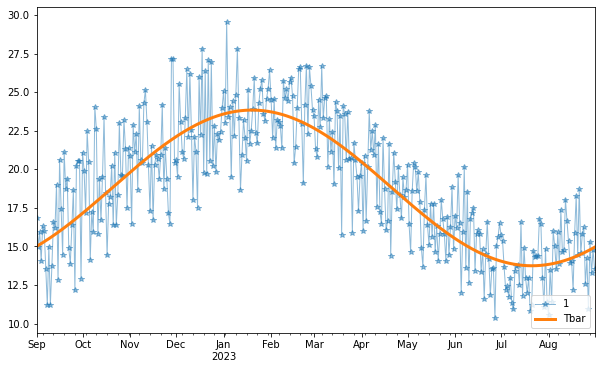

In [ ]:
# define trading date range
trading_dates = pd.date_range(start='2022-09-01', end='2023-08-31', freq='D')
volatility = spline(5, days, T_std)
mc_temps, mc_sims = monte_carlo_temp(trading_dates, Tbar_params, volatility, first_ord)

plt.figure(figsize=(10,6))
mc_sims[1].plot(alpha=0.5,linewidth=1, marker='*')
mc_temps["Tbar"].plot(linewidth=3)
plt.legend(loc='lower right')
plt.show()

## Risk-Neutral Pricing Methodology

The market for weather derivatives is a typical example of an incomplete market,
because the underlying variable, the temperature, is not tradable. Therefore we
have to consider the market price of risk $\large \lambda$, in order to obtain unique prices for such contracts.

Since there is not yet a real market from which we can
obtain prices, we assume for simplicity that the market price of risk is constant.
Furthermore, we assume that we are given a risk free asset with constant interest rate $\large r$ and a contract that for each degree Celsius pays one unit of currency.
Thus, under a martingale measure $\large \mathbb{Q}$, characterized by the market price of risk
$\large \lambda$, our price process also denoted by $\large T_t$ satisfies the following dynamics:


$\large dT_t^\mathbb{Q} = \left[\frac{d\bar{T_t}}{dt} + \kappa (\bar{T_t} - T_t) - \lambda \sigma_t \right]dt + \sigma_t dW_t^\mathbb{Q}$

Compared to the following dynamics under the physical probability measure $\large \mathbb{P}$:

$\large dT_t^\mathbb{P} = \left[\frac{d\bar{T_t}}{dt} + \kappa (\bar{T_t} - T_t)\right]dt + \sigma_t dW_t^\mathbb{P}$

We showed in a previous video we showed by applying Ito-Doeblin to our SDE where our ito process is $T_t$ with dynamics $dT_t$ as described by our mean-reverting SDE, we can arrive at the following expectation and variance.  

$\large T_t =  \bar{T_t} + (T_s -  \bar{T_s}) e^{-\kappa (t-s)}  + \int_s^t e^{-\kappa (t-u)} \sigma_u dW_u$

$\large \mathbb{E}^\mathbb{P}[T_t | F_s] = \bar{T_t} + (T_s -  \bar{T_s}) e^{-\kappa (t-s)}$

$\large \mathbb{Var}^\mathbb{P}[T_t | F_s] = \int_s^t e^{-2 \kappa (t-u)} \sigma^2_u du$

<b>Remember:</b> If the $\large \frac{d\bar{T_t}}{dt}$ is included in the temperature dynamics, under a change of measure (using Girasanov's theorem) the expectation can be shown to exactly equal to $\large \bar{T_t}$

Under the martingale measure $\large \mathbb{Q}$ the equation now becomes:


$\large T_t =  \bar{T_t} + (T_s -  \bar{T_s}) e^{-\kappa (t-s)} - \lambda \int_s^t e^{-\kappa (t-u)} \sigma_u du + \int_s^t e^{-\kappa (t-u)} \sigma_u dW_u$

$\large \mathbb{E}^\mathbb{Q}[T_t | F_s] = \mathbb{E}^\mathbb{P}[T_t | F_s] - \lambda \int_s^t e^{-\kappa (t-u)} \sigma_u du$

$\large \mathbb{Var}^\mathbb{Q}[T_t | F_s] = \int_s^t e^{-2 \kappa (t-u)} \sigma^2_u du$

### Evaluating these integrals in one interval
As long as volatility is constant throughout the interval than the following equations for risk-neutral mean, variance and covariance hold true.

Constant Volatility Along Interval: $\large \sigma_n, n \in [s,t]$

$\large \mathbb{E}^\mathbb{Q}[T_t | F_s] = \mathbb{E}^\mathbb{P}[T_t | F_s] - \frac{\lambda \sigma_n}{\kappa} (1-e^{-\kappa (t-s)})$

$\large \mathbb{Var}^\mathbb{Q}[T_t | F_s] = \frac{\sigma^2_n}{2 \kappa} (1 - e^{-2 \kappa (t-s)})$

Where: $\large 0 \leq s \leq t \leq u$

$\large \mathbb{Cov}^\mathbb{Q}[T_t T_u| F_s] = e^{-\kappa(u-t)} \mathbb{Var}^\mathbb{Q}[T_t | F_s]$

<b>Note:</b> Variance does not change.


## Temperature Options Valuation

### Method 1: Alternative Black Scholes Approach

The reference temperature for weather derivatives contracts traded at the CME is 18 degC.

$\large \xi = \alpha(DD - K)^+$

$\large DD = H_n = HDD^{N} = \sum^N_n (18-T_n)^+$

Now unfortunately in Sydney, Australia the temperature often rises well above the 18 degree threshold, however in the US during Heating Degree periods, you may often observe that for the winter months there is a very low frequency of temperatures rising above the reference temperature of 18 degC. In mathematical terms [1]:

$\large \mathbb{P}\{(18-T_n)^+ = 0\} \approx 0$

This means we can use the Gaussian OU process that under the risk-neutral measure $\large \mathbb{Q}$ is normally distributed with $\large \mu_t = \mathbb{E}^\mathbb{Q}[T_t | F_s]$ and $\large \sigma^2_t = \mathbb{Var}^\mathbb{Q}[T_t | F_s]$.

$\large T_t \sim N(\mu_t, \sigma_t)$

Therefore $\large DD$ simplifies to:

$\large DD = H_n = HDD^{N} = \sum^N_n (18-T_n)^{+} \approx 18N - \sum^N_n T_n$

$\large \mu_t = \mathbb{E}^\mathbb{Q}[H_n | F_s] \approx 18N - \sum^N_n \mathbb{E}^\mathbb{Q}[T_n | F_s]$

$\large \sigma^2_t = \mathbb{Var}^\mathbb{Q}[H_n | F_s] = Var \left( \sum^N_n T_n \right)$

$\large \sigma^2_t = \sum^N_n Var(T_n) + 2 \sum^N_{n=1} \sum^N_{n<m} Cov(T_n,T_m)$

<b>References:</b>

[1] Djehiche, Boualem, Alaton, Peter, and Stillberger, David. On modelling and pricing weather
derivatives. Applied Mathematical Finance, 9:1–20, 2002

In [ ]:
trading_dates = pd.date_range(start='2023-06-01', end='2023-08-31', freq='D')
volatility = spline(5, days, T_std)
mc_temps, mc_sims = monte_carlo_temp(trading_dates, Tbar_params, volatility, first_ord)

print('Probability P(max(18-Tn, 0) = 0): {0:1.1f}%'.format(len(mc_sims[mc_sims[1] >= 18])/len(mc_sims)*100))

Probability P(max(18-Tn, 0) = 0): 2.2%


### Black Scholes Approach

#### Risk-Neutral $\mu$
$\large \mu_t = \mathbb{E}^\mathbb{Q}[H_n | F_s] \approx 18N - \sum^N_n \mathbb{E}^\mathbb{Q}[T_n | F_s]$

$\large \mathbb{E}^\mathbb{Q}[T_t | F_s] = \mathbb{E}^\mathbb{P}[T_t | F_s] - \frac{\lambda \sigma_n}{\kappa} (1-e^{-\kappa (t-s)})$

In [ ]:
def rn_mean(time_arr, vol_arr, Tbars, lamda, kappa):
    """Evaluate the risk neutral integral above for each segment of constant volatility
    Rectangular integration with step size of days
    """
    dt = 1/365.25
    N = len(time_arr)
    mean_intervals = -vol_arr*(1 - np.exp(-kappa*dt))/kappa
    return 18*N - (np.sum(Tbars) - lamda*np.sum(mean_intervals))

#### Risk-Neutral $\sigma^2_t$
$\large \sigma^2_t = \sum^N_n Var(T_n) + 2 \sum^N_{n=1} \sum^N_{n<m} Cov(T_n,T_m)$

$\large \mathbb{Var}^\mathbb{Q}[T_t | F_s] = \frac{\sigma^2_n}{2 \kappa} (1 - e^{-2 \kappa (t-s)})$

Where: $\large 0 \leq s \leq t \leq u$

$\large \mathbb{Cov}^\mathbb{Q}[T_t T_u| F_s] = e^{-\kappa(u-t)} \mathbb{Var}^\mathbb{Q}[T_t | F_s]$

In [ ]:
def rn_var(time_arr, vol_arr, kappa):
    """Evaluate the risk neutral integral above for each segment of constant volatility
    Rectangular integration with step size of days
    """
    dt = 1/365.25
    var_arr = np.power(vol_arr,2)
    var_intervals = var_arr/(2*kappa)*(1-np.exp(-2*kappa*dt))
    cov_sum = 0
    for i, ti in enumerate(time_arr):
        for j, tj in enumerate(time_arr):
            if j > i:
                cov_sum += np.exp(-kappa*(tj-ti)) * var_intervals[i]
    return np.sum(var_intervals) + 2*cov_sum

In [ ]:
def risk_neutral(trading_dates, Tbar_params, vol_model, first_ord, lamda, kappa=0.438):
    if isinstance(trading_dates, pd.DatetimeIndex):
        trading_date=trading_dates.map(dt.datetime.toordinal)

    Tbars = T_model(trading_date-first_ord, *Tbar_params)
    dTbars = dT_model(trading_date-first_ord, *Tbar_params)
    mc_temps = pd.DataFrame(data=np.array([Tbars, dTbars]).T,
                            index=trading_dates, columns=['Tbar','dTbar'])
    mc_temps['day'] = mc_temps.index.dayofyear
    mc_temps['vol'] = vol_model[mc_temps['day']-1]
    time_arr = np.array([i/365.25 for i in range(1,len(trading_dates)+1)])
    vol_arr = mc_temps['vol'].values
    mu_rn = rn_mean(time_arr, vol_arr, Tbars, lamda, kappa)
    var_rn = rn_var(time_arr, vol_arr, kappa)
    return mu_rn, var_rn

### Closed-form Solution

Using the fundamental theorem of asset pricing, we have the following Risk-Neutral Pricing formulation.

$\begin{equation}\large
\frac{C_t}{B_t} = \mathbb{E}_{\mathbb{Q}}[\frac{C_T}{B_T}\mid F_t]
\end{equation}$

$\begin{equation}\large
C_t = B_t \mathbb{E}_{\mathbb{Q}}[\frac{C_T}{B_T}\mid F_t]
\end{equation}$

<b>Call Option:</b> $\large \xi = \alpha(DD - K)^+$

$\large C_t = B_t \mathbb{E}_{\mathbb{Q}}[\alpha(DD - K)^+]$

$\large C_t = \alpha e^{-r(T-t)} \int^\infty_K (x-K)f_{DD}(x)dx$

$\large C_t = \alpha e^{-r(T-t)} \left( (\mu_t - K) \Phi(-Z_t) + \frac{\sigma_t}{\sqrt{2\pi}} e^{-\frac{Z_t^2}{2}}\right)$

where: $\large Z_t = \frac{K - \mu_t}{\sigma_t}$ and $\large \Phi$ is the CDF of the Normal Distribution.

<b>Put Option:</b> $\large \xi = \alpha(K - DD)^+$

$\large P_t = B_t \mathbb{E}_{\mathbb{Q}}[\alpha(K - DD)^+]$

$\large P_t = \alpha e^{-r(T-t)} \int^K_0 (K-x)f_{DD}(x)dx$

$\large P_t = \alpha e^{-r(T-t)} \left( (K - \mu_t) \left(\Phi(Z_t) - \Phi(-\frac{\mu_t}{\sigma_t})\right)+ \frac{\sigma_t}{\sqrt{2\pi}} \left( e^{-\frac{Z_t^2}{2}} - e^{-\frac{u_t^2}{2 \sigma^2_t}} \right) \right)$

In [ ]:
def winter_option(trading_dates, r, alpha, K, tau, opt='c', lamda=0.0):
    """Evaluate the fair value of temperature option in winter
    Based on heating degree days only if the physical probability that
    the average temperature exceeds the Tref (18 degC) is close to 0
    """
    mu_rn, var_rn = risk_neutral(trading_dates, Tbar_params, volatility, first_ord, lamda)
    disc = np.exp(-r*tau)
    vol_rn = np.sqrt(var_rn)
    zt = (K - mu_rn)/vol_rn
    exp = np.exp(-zt**2/2)
    if opt == 'c':
        return alpha*disc*((mu_rn - K)*stats.norm.cdf(-zt) + vol_rn*exp/np.sqrt(2*np.pi))
    else:
        exp2 = np.exp(-mu_rn**2/(2*vol_rn**2))
        return alpha*disc*((K - mu_rn)*(stats.norm.cdf(zt) - stats.norm.cdf(-mu_rn/vol_rn)) +
                           vol_rn/np.sqrt(2*np.pi)*(exp-exp2))

In [ ]:
trading_dates = pd.date_range(start='2023-06-01', end='2023-08-31', freq='D')
r=0.05
K=300
alpha=2500

def years_between(d1, d2):
    d1 = dt.datetime.strptime(d1, "%Y-%m-%d")
    d2 = dt.datetime.strptime(d2, "%Y-%m-%d")
    return abs((d2 - d1).days)/365.25

start = dt.datetime.today().strftime('%Y-%m-%d')
end = '2023-08-31'

tau = years_between(start, end)

print('Start Valuation Date:', start,
      '\nEnd of Contract Date:', end,
      '\nYears between Dates :', round(tau,3))

Start Valuation Date: 2022-10-16 
End of Contract Date: 2023-08-31 
Years between Dates : 0.873


In [ ]:
print('Call Price: ', round(winter_option(trading_dates, r, alpha, K, tau, 'c'),2))
print('Put Price : ', round(winter_option(trading_dates, r, alpha, K, tau, 'p'),2))

Call Price:  103247.41
Put Price :  0.0


### Method 2: Monte Carlo Valuation


$\begin{equation}\large
\frac{C_t}{B_t} = \mathbb{E}_{\mathbb{Q}}[\frac{C_T}{B_T}\mid F_t]
\end{equation}$

$\begin{equation}\large
C_t = B_t \mathbb{E}_{\mathbb{Q}}[\frac{C_T}{B_T}\mid F_t]
\end{equation}$

<b>Call Option:</b> $\large \xi = \alpha(DD - K)^+$

$\large C_t = e^{-r\tau} \mathbb{E}_{\mathbb{Q}}[\alpha(DD - K)^+ \mid F_t]$

For each simulation $\Large m \in M$, there is a resulting number of Degree Days in the valuation period.
- $\large DD = H_n = HDD^{N} = \sum^N_n (18-T_n)^{+}$

$\large C_t = e^{-r\tau} \frac{1}{M} \sum^M_{m=1} [\alpha(DD_m - K)^+]$



In [ ]:
# define trading date range
trading_dates = pd.date_range(start='2023-06-01', end='2023-08-31', freq='D')
no_sims = 10000
vol_model = spline(5, days, T_std)

In [ ]:
def temperature_option(trading_dates, no_sims, Tbar_params, vol_model, r, alpha, K, tau, first_ord, opt='c'):
    "Evaluates the price of a temperature call option"
    mc_temps, mc_sims = monte_carlo_temp(trading_dates, Tbar_params, volatility, first_ord, no_sims)
    N, M = np.shape(mc_sims)
    mc_arr = mc_sims.values
    DD = np.sum(np.maximum(18-mc_arr,0), axis=0)
    if opt == 'c':
        CT = alpha*np.maximum(DD-K,0)
    else:
        CT = alpha*np.maximum(K-DD,0)
    C0 = np.exp(-r*tau)*np.sum(CT)/M
    sigma = np.sqrt( np.sum( (np.exp(-r*tau)*CT - C0)**2) / (M-1) )
    SE = sigma/np.sqrt(M)
    return C0, SE

In [ ]:
call = np.round(temperature_option(trading_dates, no_sims, Tbar_params, vol_model, r, alpha, K, tau, first_ord, 'c'),2)
put = np.round(temperature_option(trading_dates, no_sims, Tbar_params, vol_model, r, alpha, K, tau, first_ord, 'p'),2)
print('Call Price: {0} +/- {1} (2se)'.format(call[0], call[1]*2))
print('Put Price : {0} +/- {1} (2se)'.format(put[0], put[1]*2))

Call Price: 111585.88 +/- 874.24 (2se)
Put Price : 54.93 +/- 20.66 (2se)


## Comparing the two Methods

In [ ]:
strikes = np.arange(180,520,20)
strikes

array([180, 200, 220, 240, 260, 280, 300, 320, 340, 360, 380, 400, 420,
       440, 460, 480, 500])

In [ ]:
data = np.zeros(shape=(len(strikes),4))
for i, strike in enumerate(strikes):
    data[i,0] = temperature_option(trading_dates, no_sims, Tbar_params, vol_model, r, alpha, strike, tau, first_ord, 'c')[0]
    data[i,1] = winter_option(trading_dates, r, alpha, strike, tau, 'c')
    data[i,2] = temperature_option(trading_dates, no_sims, Tbar_params, vol_model, r, alpha, strike, tau, first_ord, 'p')[0]
    data[i,3] = winter_option(trading_dates, r, alpha, strike, tau, 'p')

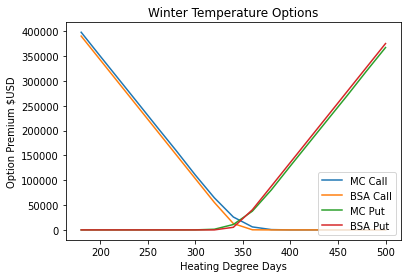

In [ ]:
df = pd.DataFrame({'MC Call': data[:, 0], 'BSA Call': data[:, 1], 'MC Put': data[:, 2], 'BSA Put': data[:, 3]})
df.index = strikes

plt.plot(df)
plt.title('Winter Temperature Options')
plt.ylabel('Option Premium $USD')
plt.xlabel('Heating Degree Days')
plt.legend(df.columns, loc=4)
plt.show()